Обучите простую модель предсказания цены акций. Используйте рассмотренные на лекции алгоритмы предсказания рядов (не менее двух,например, модель Хольта-Уинтерса и SARIMA). Можно использовать и более сложные алгоритмы предсказания рядов


1. Найдите данные о цене любого биржевого актива

    Данные должны содержать значение цены актива как минимум за каждый день и длительностю как минимум за год. 

    Найти данные можно на kaggle или использовать FAANG датасет из 1-й лабораторной


2. Предобработайте данные

    Временной ряд сложно предсказывать по дням. Сделайте ряд по неделям или месяцам
   
    Удалите из ряда тренд, если он есть. Используйте другие рассмотренные на лекции приёмы


3. Обучите модель
    
    Обучите модели на 80% временного ряда
    
    Предскажите оставшиеся 20% (как минимум 3 точки) ряда с помощью моделей 
    
    Отобразите на графике предсказание моделей и истинные данные


4. Посчитайте метрику

    Метрика должна отражать разницу между предсказанными и истинными данными. Можно выбрать меру MAPE, можно предложить свою

In [1]:
import numpy as np
import pandas
import matplotlib.pyplot as plt
import statsmodels.api
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf
from tqdm import tqdm
from sklearn.metrics import mean_absolute_percentage_error
from itertools import product

In [2]:
plt.rcParams['figure.figsize'] = (18, 8)
plt.rcParams['font.size'] = 20

In [3]:
df = pandas.read_csv("data/raw/Stock price/Amazon_Historical_StockPrice2.csv")
df["Date"] = pandas.to_datetime(df["Date"], format="%Y/%m/%d")
df = df.set_index(df["Date"])
df.sort_index(inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2016-03-28 to 2021-03-26
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       1260 non-null   datetime64[ns]
 1   Open       1260 non-null   float64       
 2   High       1260 non-null   float64       
 3   Low        1260 non-null   float64       
 4   Close      1260 non-null   float64       
 5   Adj Close  1260 non-null   float64       
 6   Volume     1260 non-null   int64         
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 78.8 KB


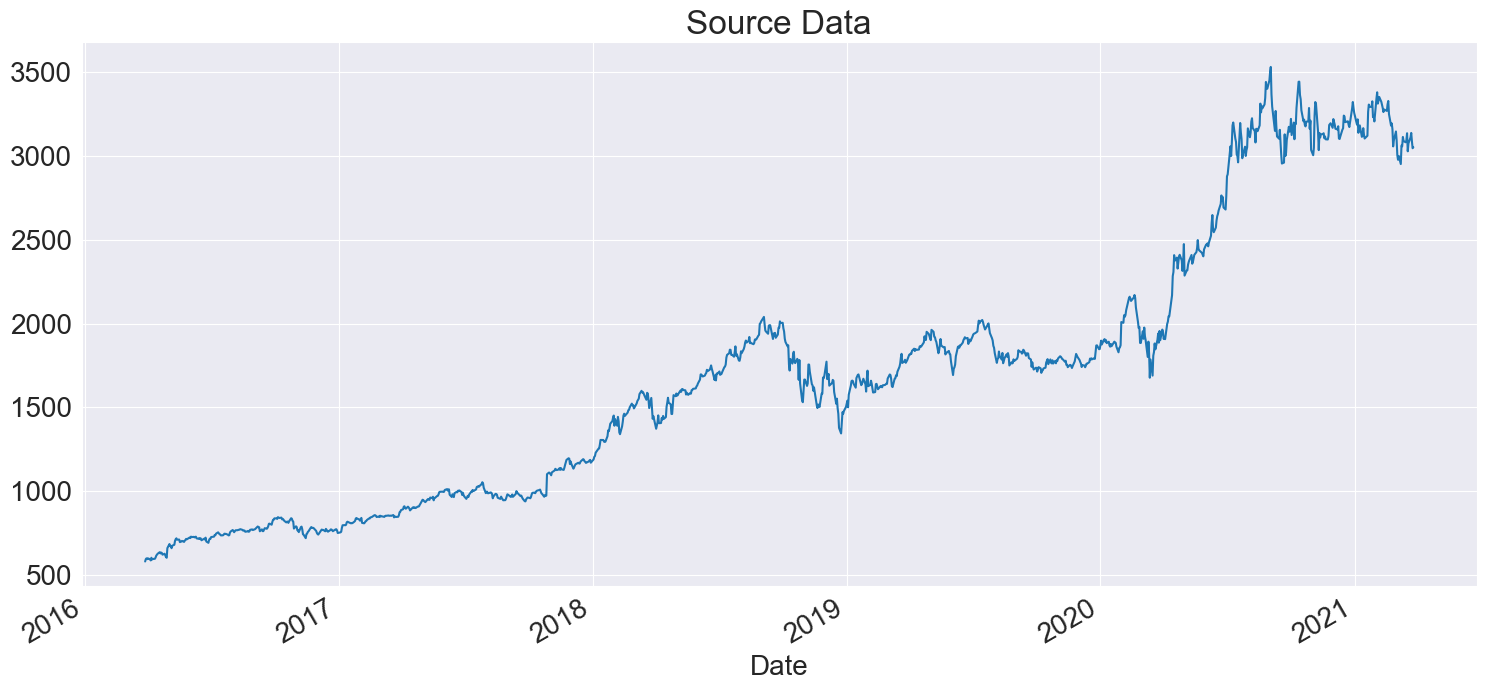

In [4]:
df["Close"].plot(title="Source Data")
plt.show()

C:\Users\asustuf\AppData\Local\Temp\ipykernel_39312\938884434.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.resample("M").mean()


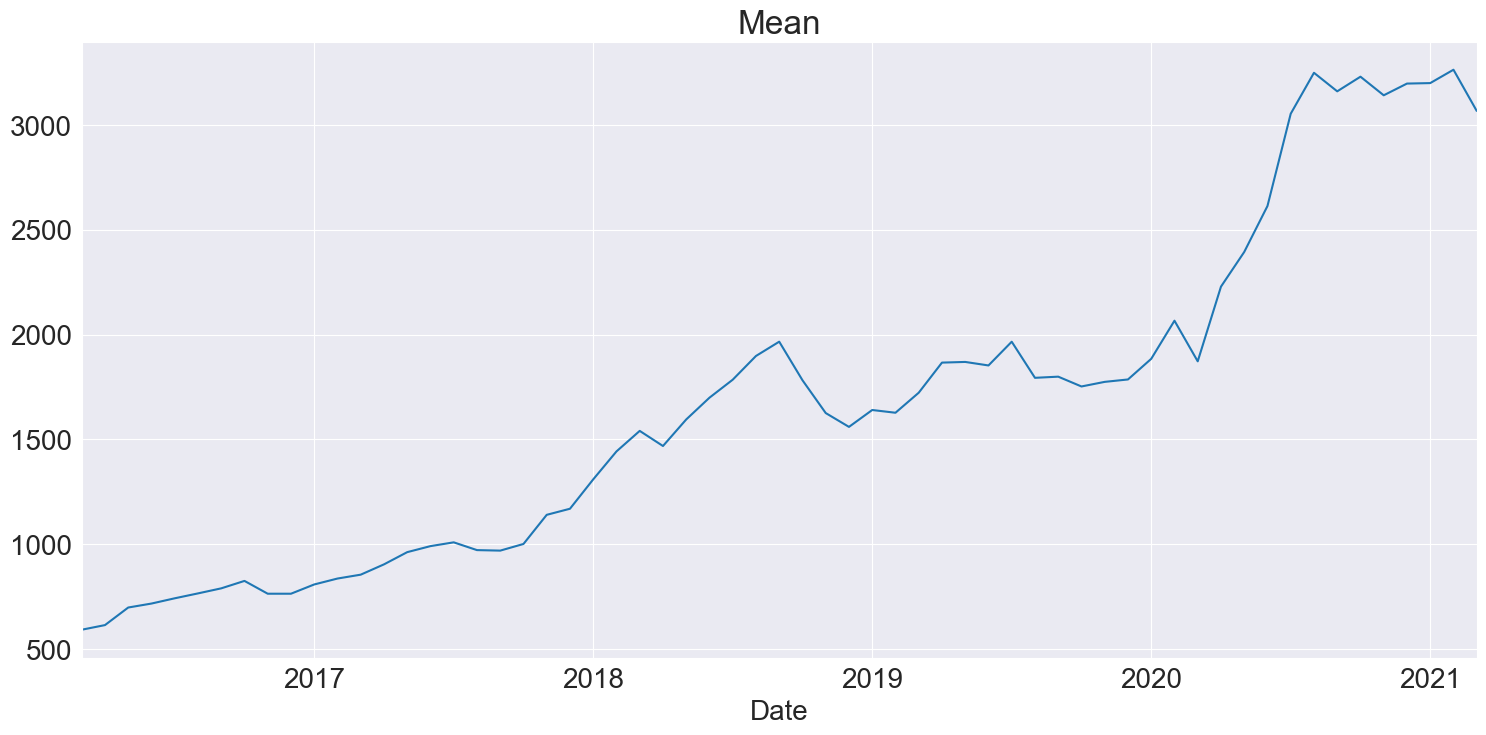

In [5]:
df = df.resample("M").mean()
df["Close"].plot(title="Mean")
plt.show()

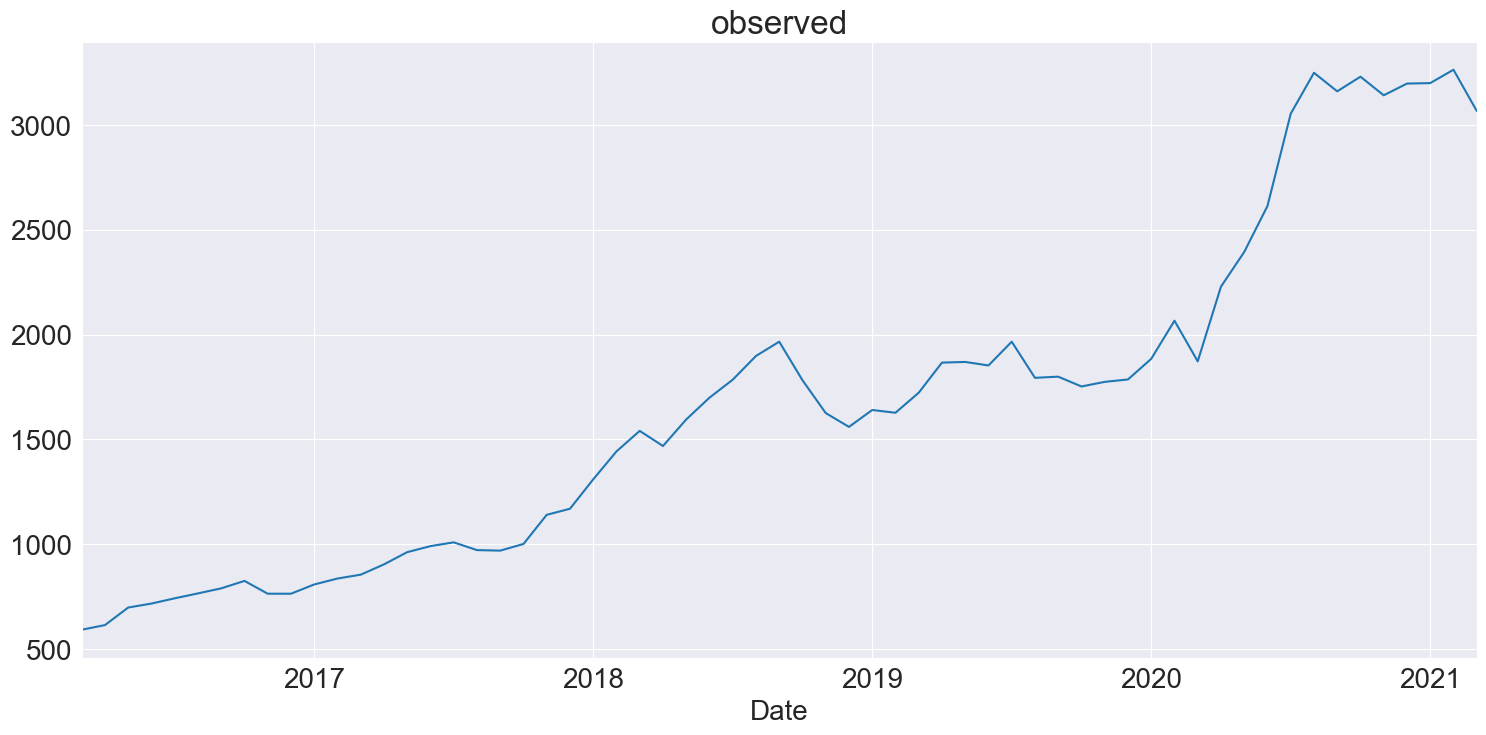

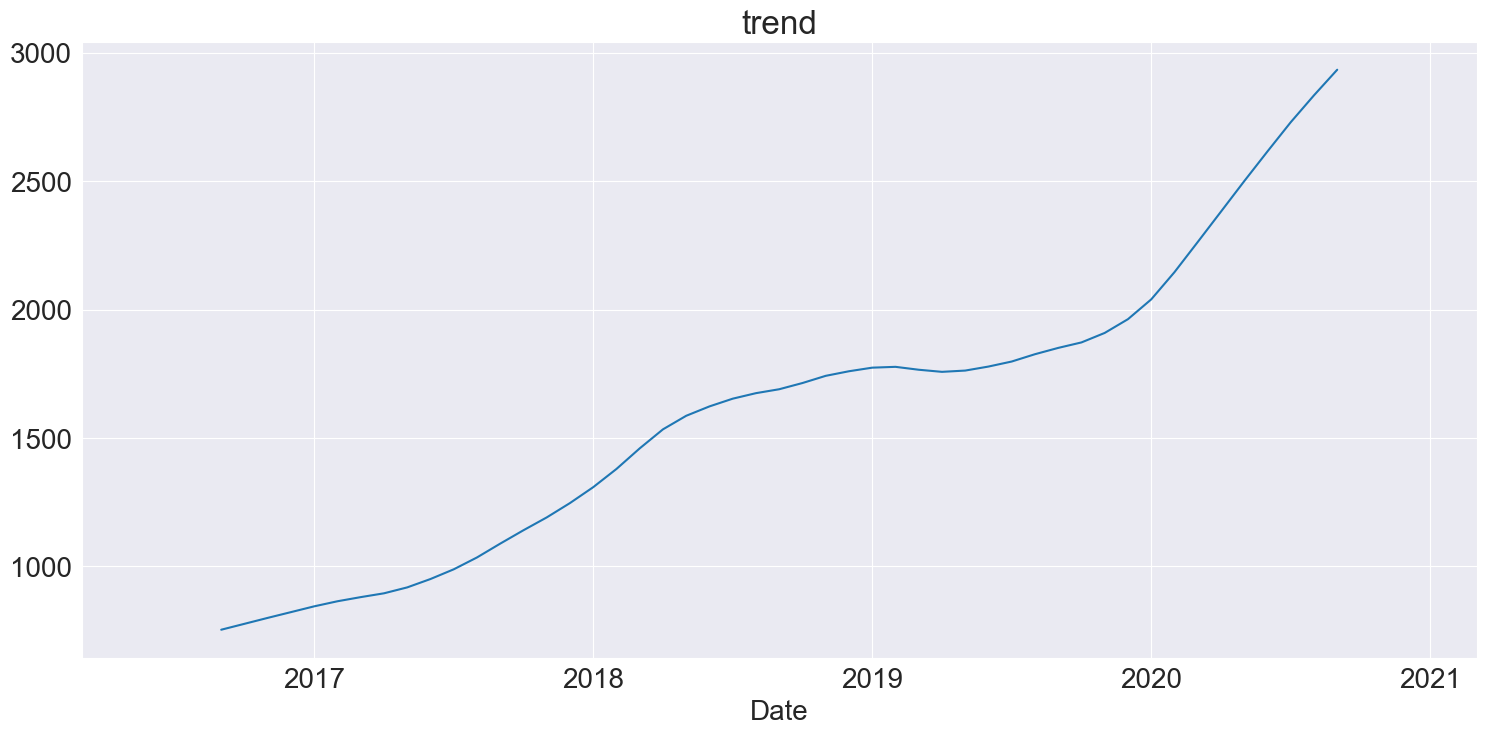

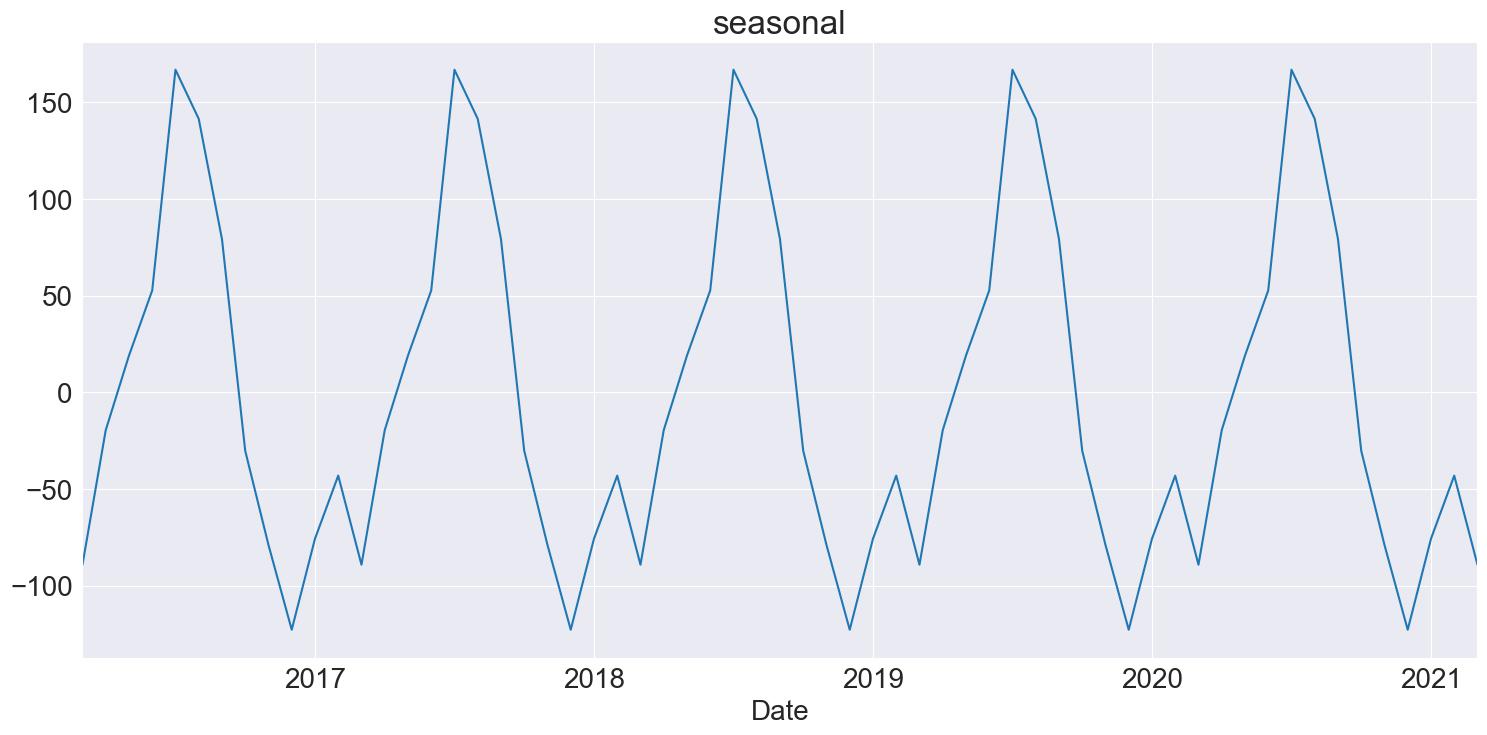

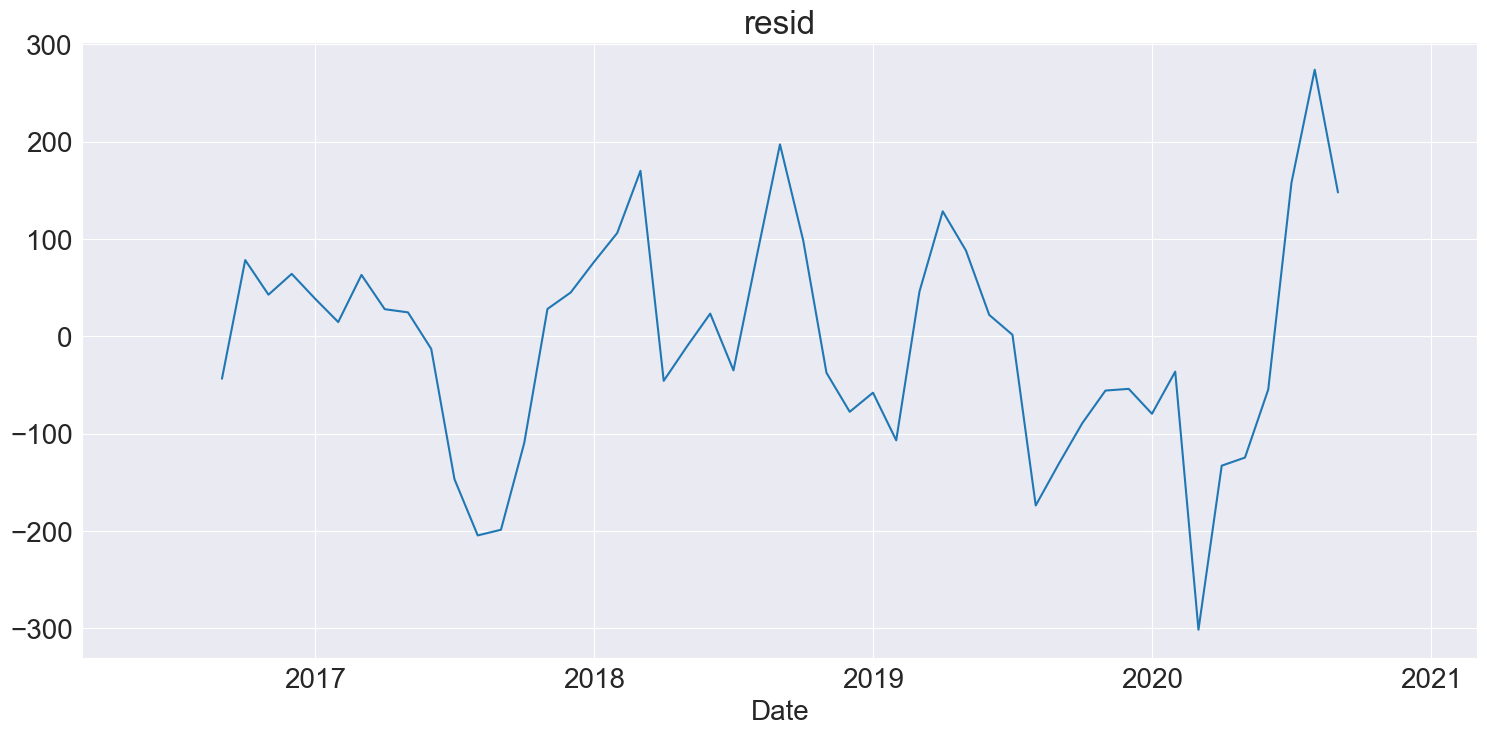

In [6]:
decompose = seasonal_decompose(df["Close"], period=12)

decompose.observed.plot(title="observed")
plt.show()
decompose.trend.plot(title="trend")
plt.show()
decompose.seasonal.plot(title="seasonal")
plt.show()
decompose.resid.plot(title="resid")
plt.show()

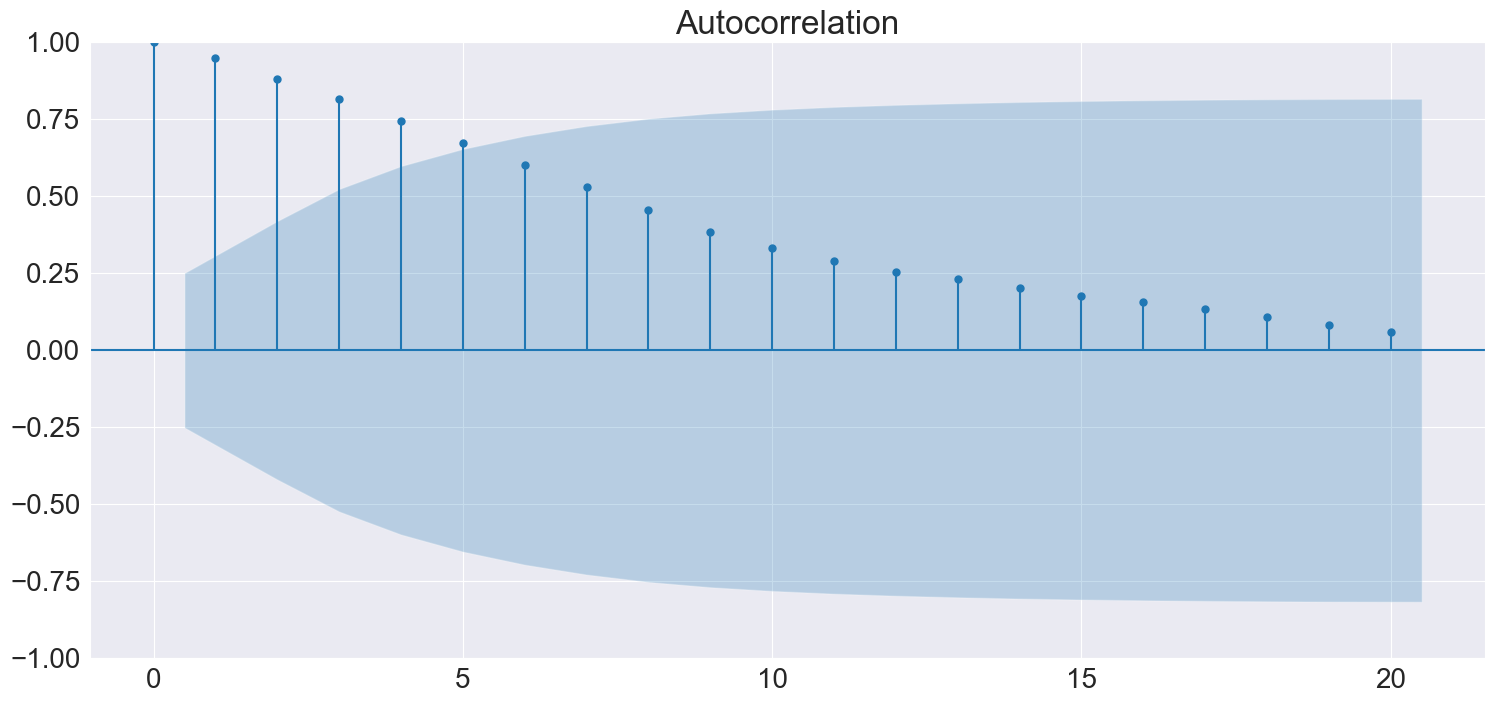

In [7]:
plot_acf(df["Close"], lags=20)
plt.show()

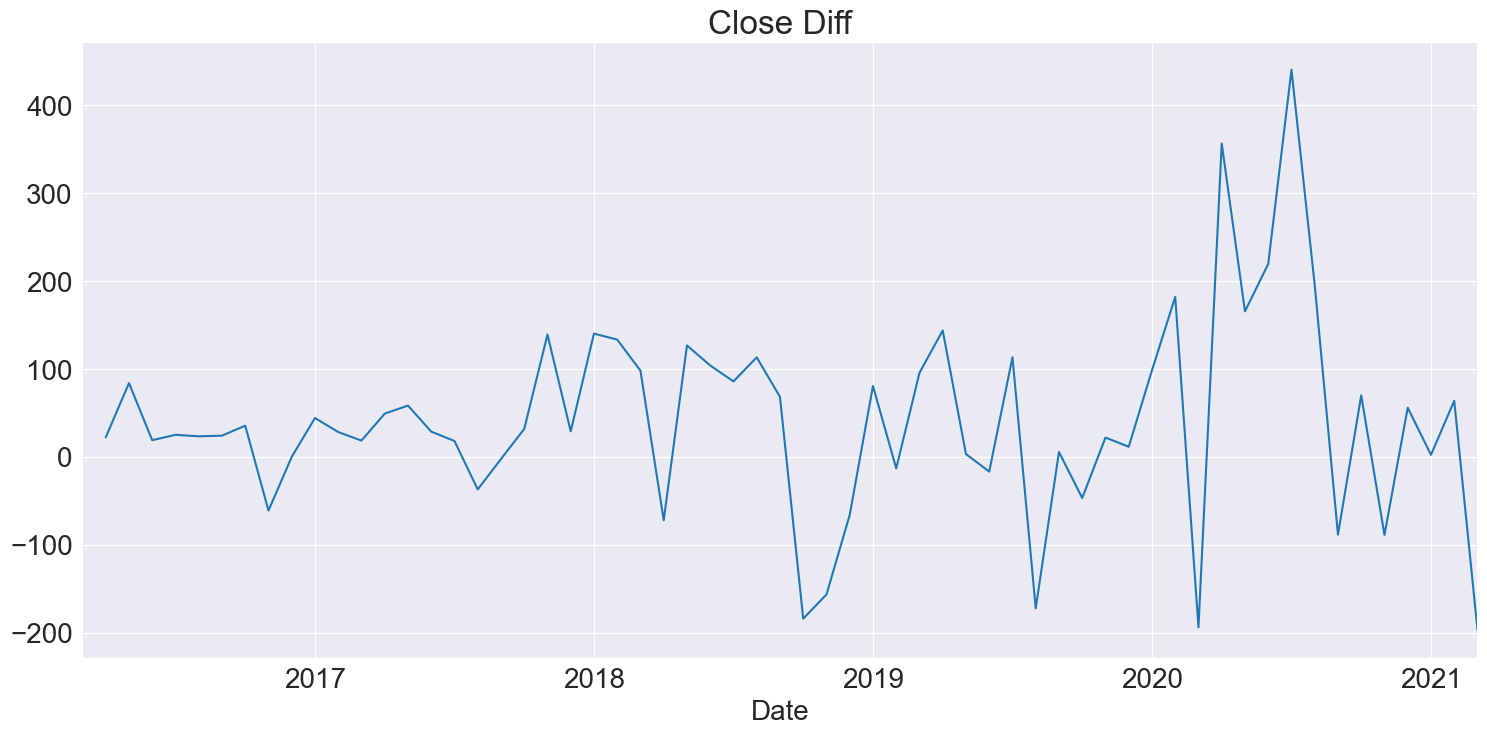

In [8]:
df["Close Diff"] = df["Close"].diff()
df["Close Diff"].plot(title="Close Diff")
plt.show()

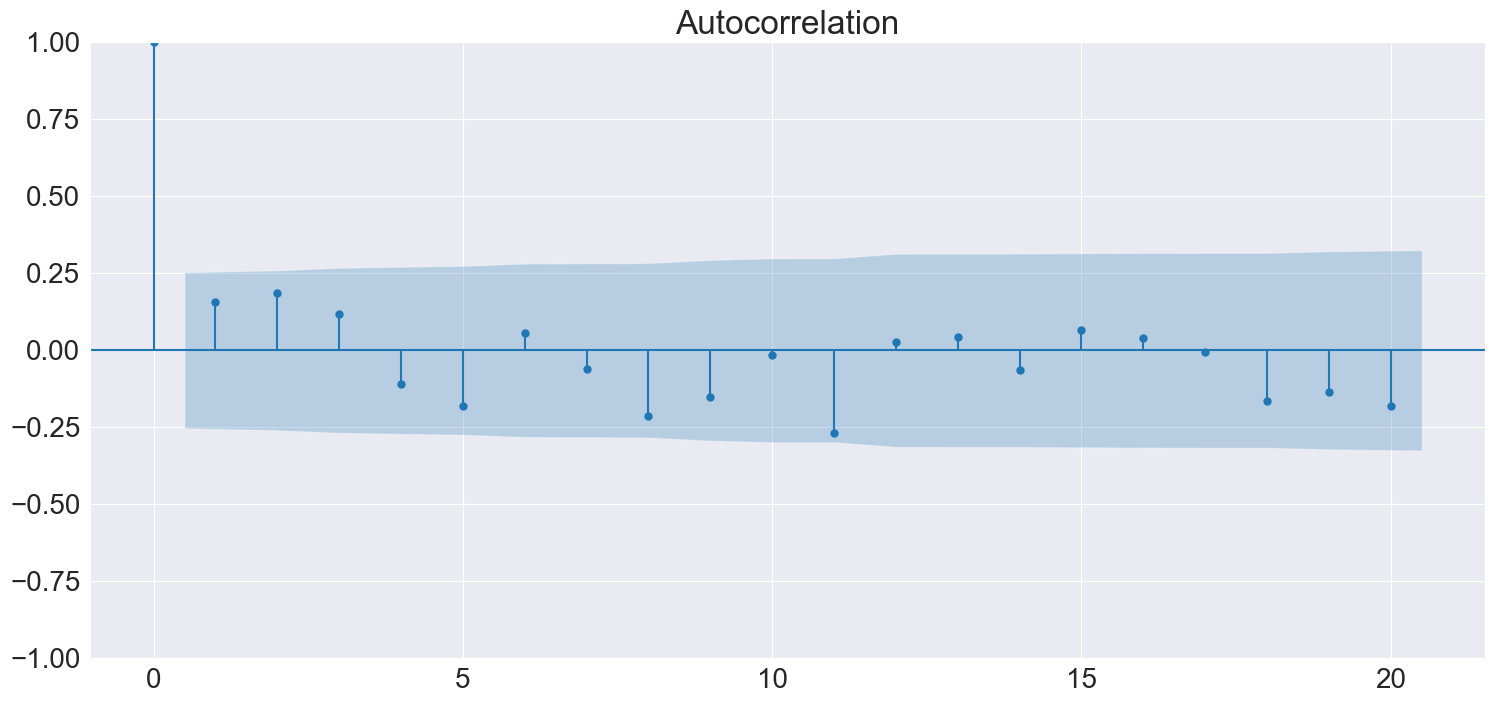

In [9]:
plot_acf(df["Close Diff"][1:], lags=20)
plt.show()

p-value = 0.0035393685208277934


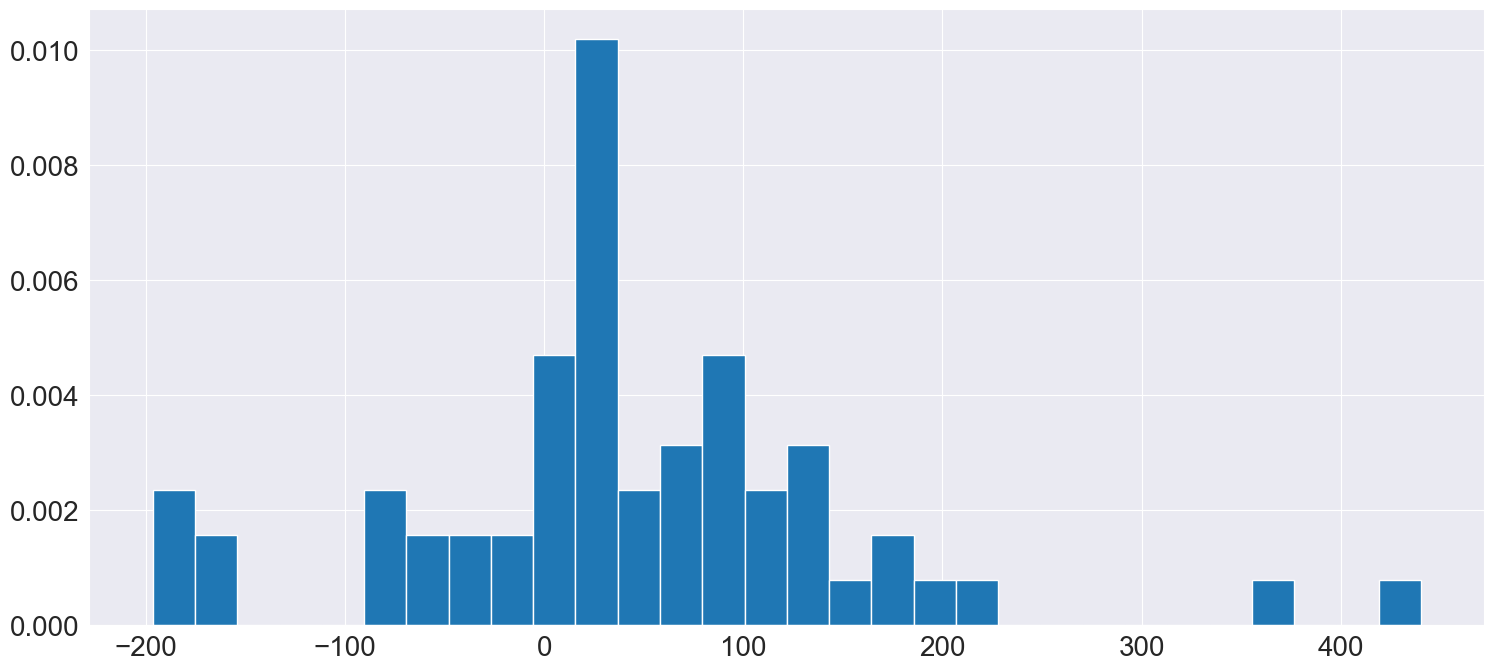

In [10]:
print(f'p-value = {adfuller(df["Close Diff"][1:])[1]}')
plt.hist(df["Close Diff"], density=True, bins=30)
plt.show()

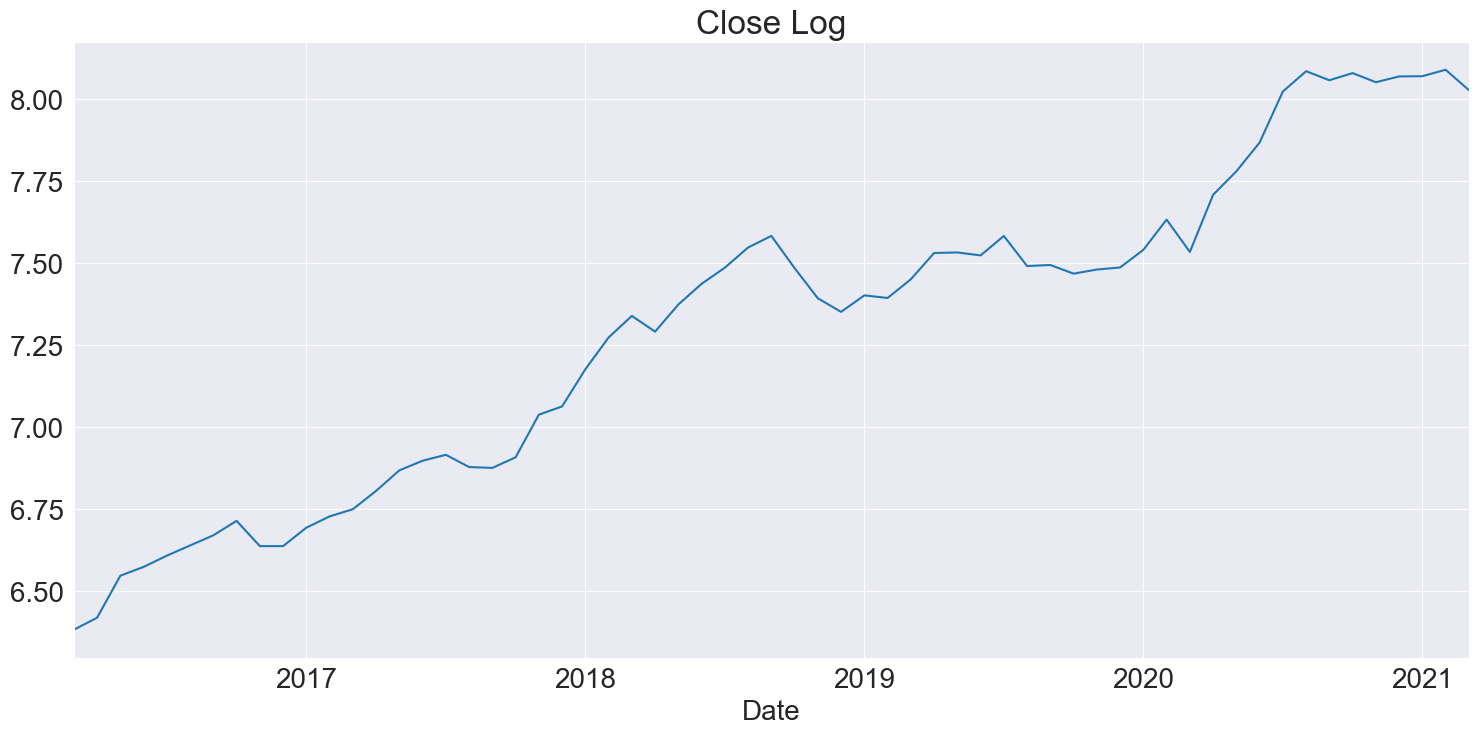

In [11]:
df["Close Log"] = np.log(df["Close"])
df["Close Log"].plot(title="Close Log")
plt.show()

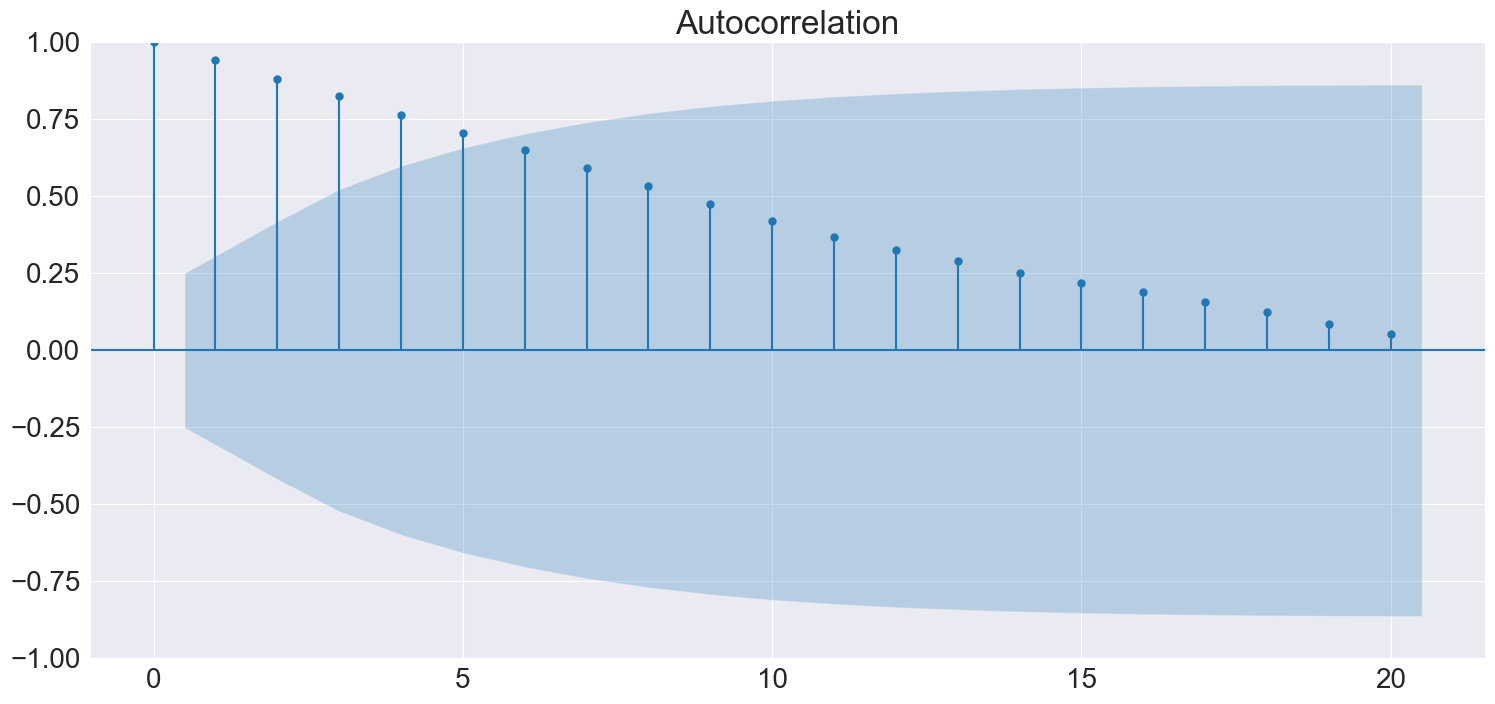

In [12]:
plot_acf(df["Close Log"], lags=20)
plt.show()

p-value = 0.6706066805367461


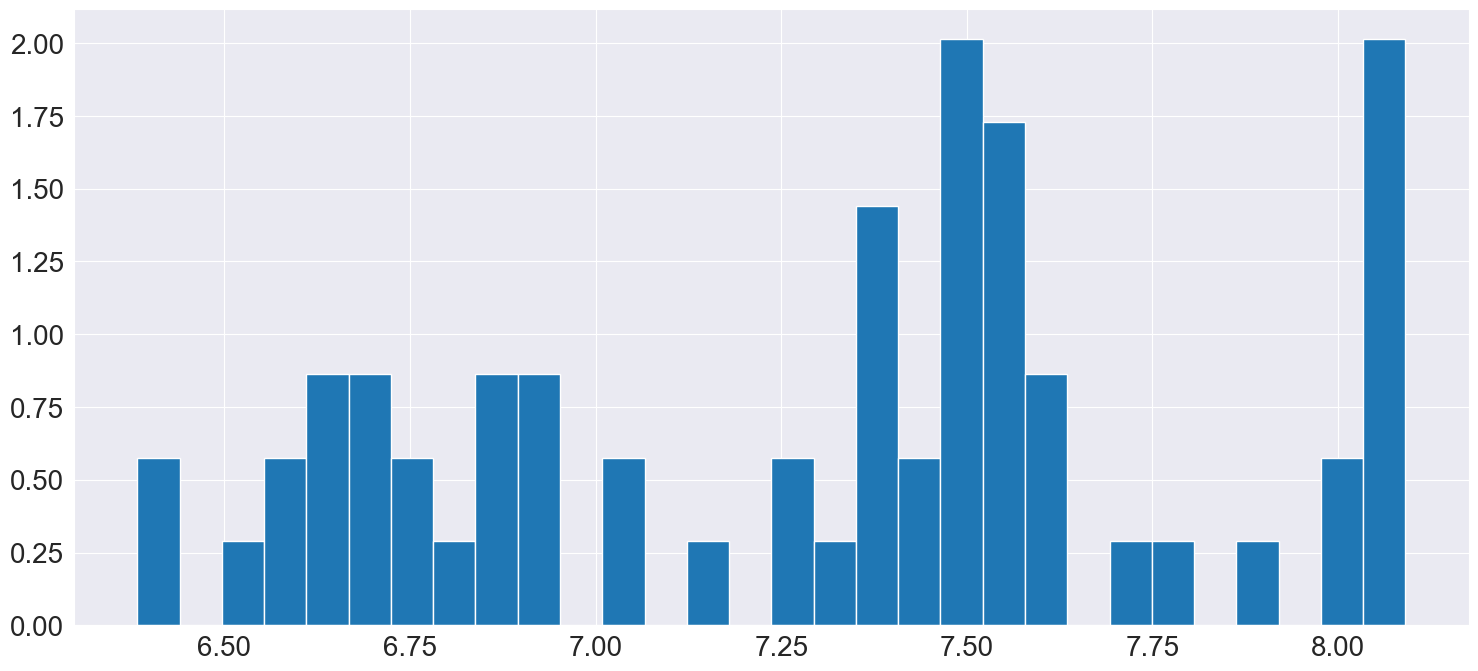

In [13]:
print(f'p-value = {adfuller(df["Close Log"])[1]}')
plt.hist(df["Close Log"], density=True, bins=30)
plt.show()

In [14]:
import warnings

train = int(len(df) * 0.8)

warnings.filterwarnings("ignore")
best_model = None
best_param = np.Inf
in_params = None


for (p, d, q, P, Q) in tqdm(list(product(range(0, 3),
                                         range(0, 2),
                                         range(0, 5),
                                         range(0, 2),
                                         range(0, 3)))):
    model = statsmodels.api.tsa.SARIMAX(df["Close Log"].head(train),
                                        order=(p, d, q),
                                        seasonal_order=(P, 1, Q, 12),
                                        ).fit(disp=-1)
    if best_param > model.aic:
        best_model = model
        best_param = model.aic
        in_params = (p, d, q, P, Q)



100%|██████████| 180/180 [01:40<00:00,  1.79it/s]


In [15]:
print(best_param)
print(in_params)
print(best_model.summary())

-93.86086162616112
(0, 1, 0, 1, 0)
                                     SARIMAX Results                                      
Dep. Variable:                          Close Log   No. Observations:                   48
Model:             SARIMAX(0, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  48.930
Date:                            Tue, 18 Oct 2022   AIC                            -93.861
Time:                                    17:48:50   BIC                            -90.750
Sample:                                03-31-2016   HQIC                           -92.787
                                     - 02-29-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L12      -0.7812      0.076    -10.240      0.000      -0.931      -0.632


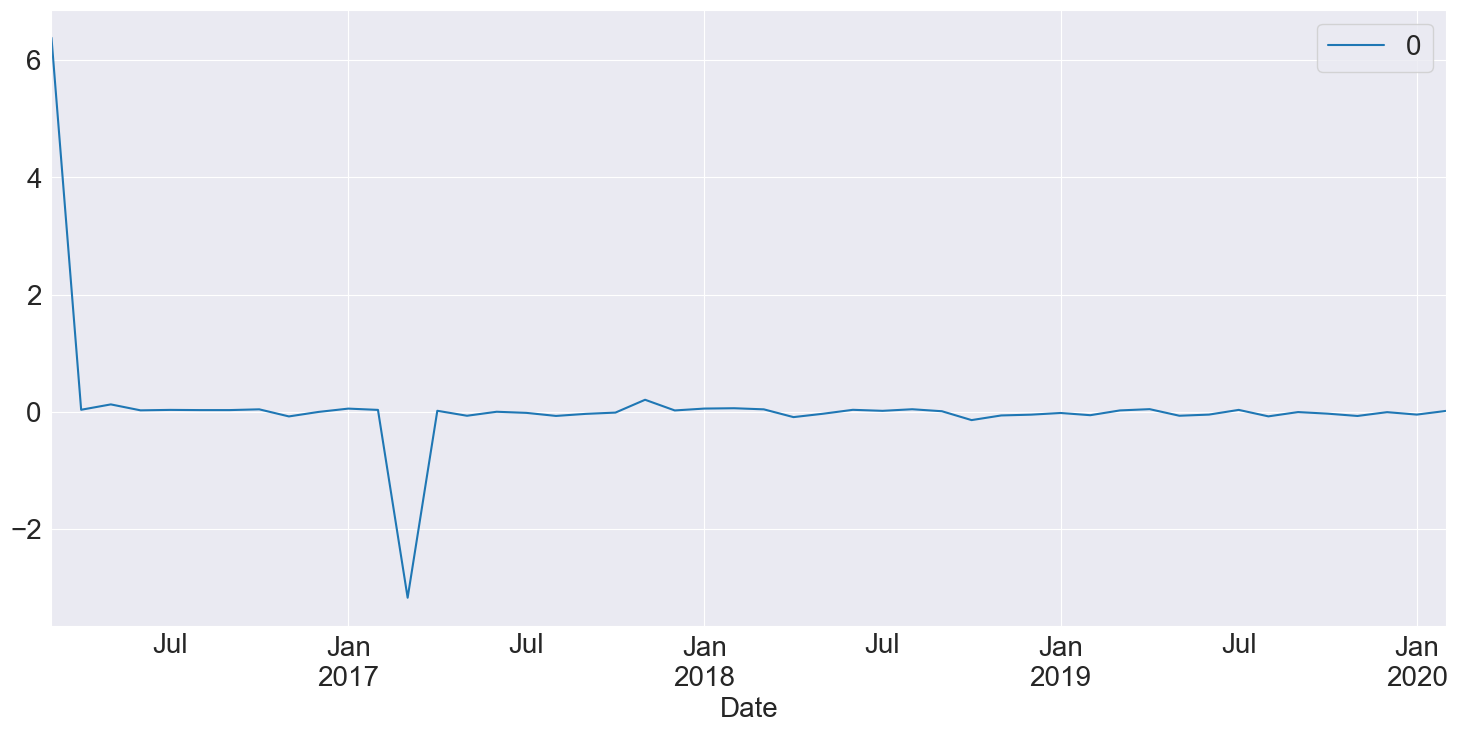

In [16]:
res = pandas.DataFrame(best_model.resid)
res.plot()
plt.show()

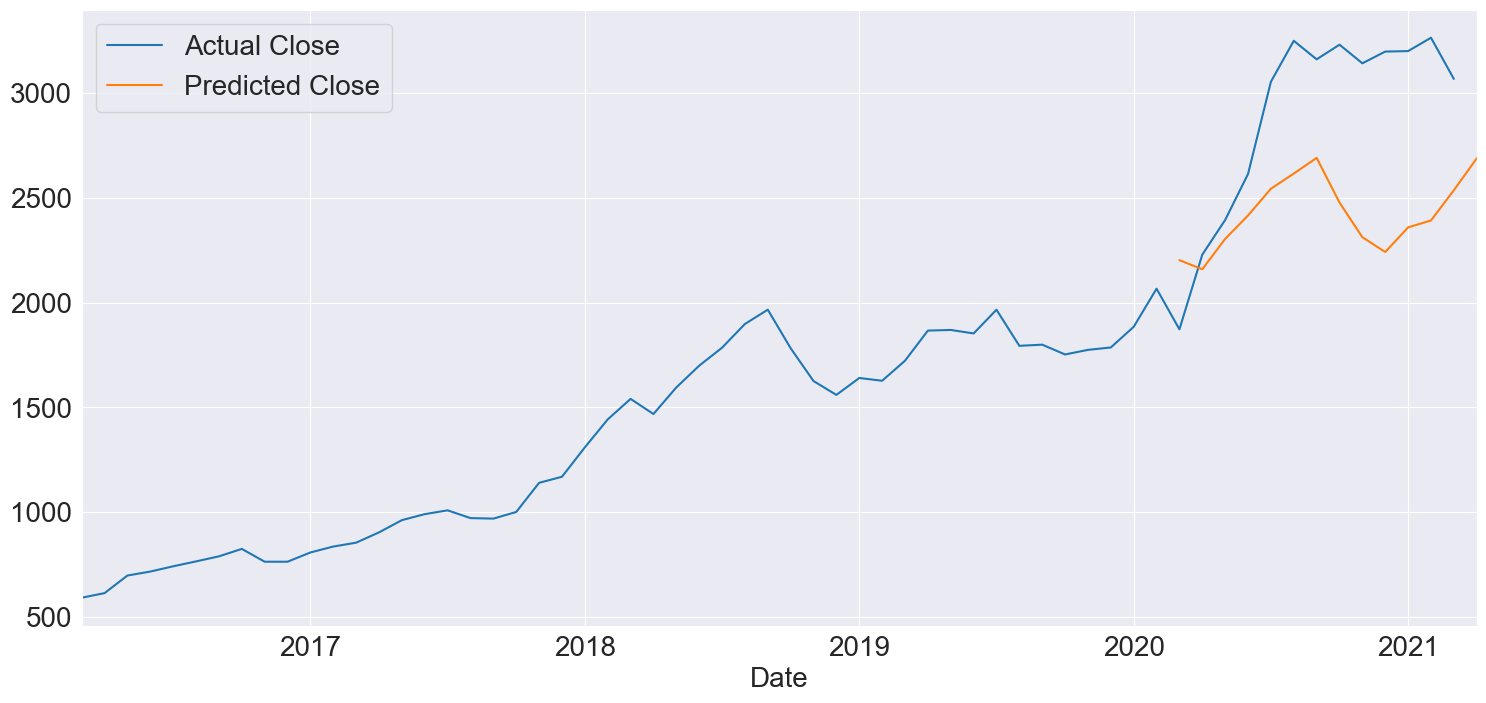

In [17]:
predicted = np.exp(best_model.predict(start=0, end=len(df)))

df["Close"].plot()
predicted[train:].plot()
plt.legend(["Actual Close", "Predicted Close"])
plt.show()

In [18]:
mean_absolute_percentage_error(predicted[train+1:], df["Close"][train:])

0.21337984930603987

In [19]:
def HolterWinter(data, L, alpha, beta, gamma, m):
    # находим изначальные сезонности
    season_num = int(len(data)/L)# кол-во cезонов
    seasonalities = {} # сами сезонности
    season_avgs = [] # их среднее
    # находим сезонное среднее
    season_avgs = [sum(data[L*i: L*i+L])/float(L) for i in range(season_num)]
    # находим начальные значения cезонности
    for i in range(L):
        avg_over_summ = 0.0
        for j in range(season_num):
            avg_over_summ += data[L*j+i] - season_avgs[j]
        seasonalities[i] = avg_over_summ / season_num
    # инициализируем массивы результирующих прогнозов, сгалженных, сезонных и трендовых (нужны в формулах на пред шагах)
    result = []
    smooth = []
    season = []
    trend = []
    # пройдемся по всем данным + длинна предсказания m
    for i in range(len(data) + m):
        # инициализируем значения шага 0
        if i==0:
            smooth_val = data[0] # первое значения сглаживания
            trend_val = sum([(float(data[i+L] - data[i]) / L) for i in range(L)]) / L # первое значения тренда
            result.append(data[0]) # первая точка данных совпадает с исходной
            smooth.append(smooth_val) # добавляем первое значение сглаживание в массив трендов
            trend.append(trend_val) # добавляем первое значение тренда в массив трендов
            season.append(seasonalities[i%L]) # см mod L
            continue # завершаем первый шаг
        # выполняем прогноз, если вышли за пределы данных
        if i >= len(data):
            # текущее прогнозируемое значение t+1, t+2, ... (текущее m)
            curr_m = i - len(data) + 1
            result.append((smooth_val + curr_m*trend_val) + seasonalities[i%L])
        else: # основной цикл вычисления параметров
            last_smooth_val = smooth_val
            smooth_val = alpha*(data[i] - seasonalities[i%L]) + (1 - alpha)*(smooth_val + trend_val) # обновляем lx
            trend_val = beta * (smooth_val - last_smooth_val) + trend_val*(1 - beta) # обновляем bx
            seasonalities[i%L] = gamma * (data[i] - smooth_val) + (1 - gamma)*seasonalities[i%L] # обновляем sx
            result.append(smooth_val + trend_val + seasonalities[i%L]) # записываем результат

            smooth.append(smooth_val)
            trend.append(trend_val)
            season.append(seasonalities[i%L])
    return result[-m:]

In [20]:
expected_pred = len(df) - train
best_pred = None
best_error = np.inf
params = None

for (L, alpha, beta, gamma) in tqdm(list(product(np.arange(1, 20),
                                         np.arange(0.1, 0.95, 0.05),
                                         np.arange(0.1, 0.95, 0.05),
                                         np.arange(0.1, 0.95, 0.05),))):
    pred_h = HolterWinter(df["Close Log"].head(train), L, alpha, beta, gamma, expected_pred)
    pred_h = np.exp(pred_h)
    cur_error = mean_absolute_percentage_error(pred_h, df["Close"][train:])
    if best_error > cur_error:
        best_pred = pred_h
        best_error = cur_error
        params = (L, alpha, beta, gamma)



100%|██████████| 93347/93347 [01:01<00:00, 1523.22it/s]


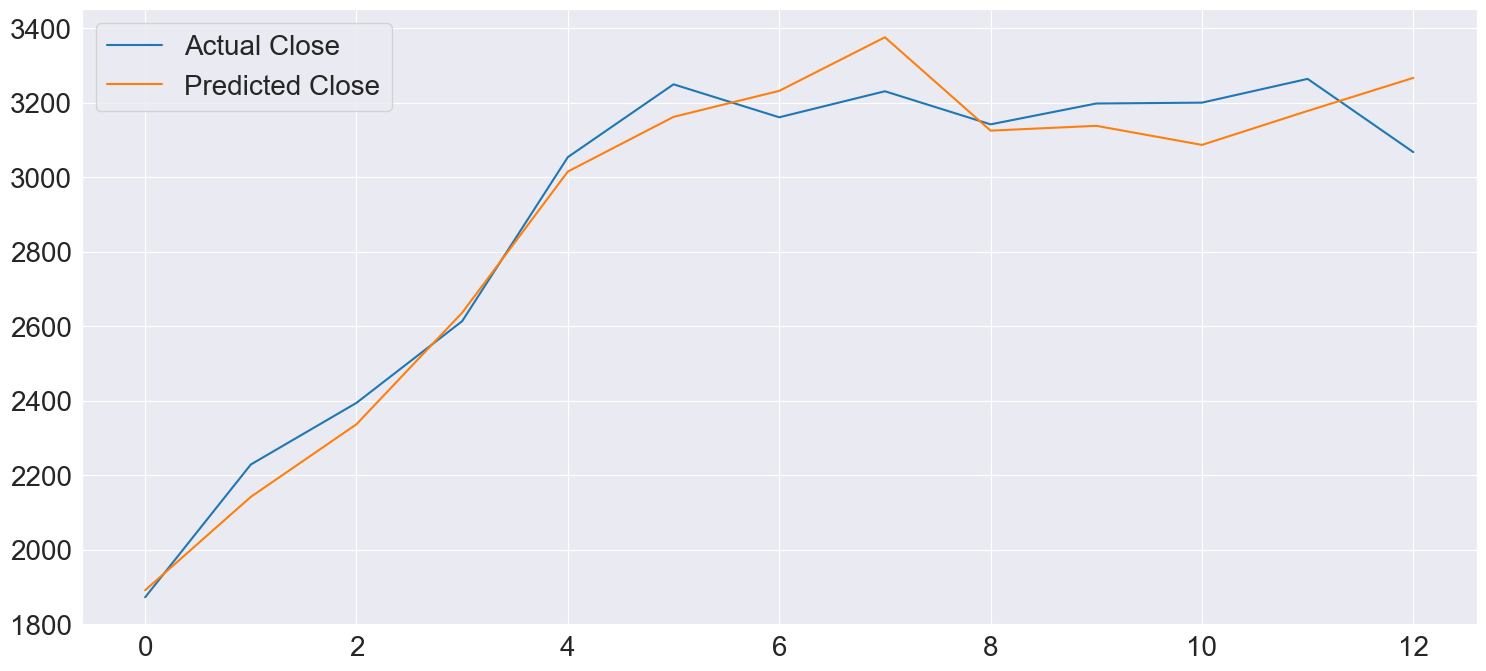

In [21]:
plt.plot(df["Close"][train:].values)
plt.plot(best_pred)
plt.legend(["Actual Close", "Predicted Close"])
plt.show()

In [22]:
print(f"L = {params[0]}, alpha = {params[1]}, beta = {params[2]}, gamma = {params[3]}")
print(best_error)

L = 15, alpha = 0.15000000000000002, beta = 0.40000000000000013, gamma = 0.9000000000000002
0.026028500689671625


In [23]:
import warnings

train2 = int(len(df) * 0.6)
last = int(len(df) * 0.8)

warnings.filterwarnings("ignore")
best_model2 = None
best_param2 = np.Inf
in_params2 = None


for (p, d, q, P, Q) in tqdm(list(product(range(0, 3),
                                         range(0, 2),
                                         range(0, 5),
                                         range(0, 2),
                                         range(0, 3)))):
    model = statsmodels.api.tsa.SARIMAX(df["Close Log"].head(train2),
                                        order=(p, d, q),
                                        seasonal_order=(P, 1, Q, 12),
                                        ).fit(disp=-1)
    if best_param2 > model.aic:
        best_model2 = model
        best_param2 = model.aic
        in_params2 = (p, d, q, P, Q)



100%|██████████| 180/180 [01:29<00:00,  2.00it/s]


In [24]:
print(best_param2)
print(in_params2)
print(best_model2.summary())


-53.97946228170595
(1, 1, 0, 1, 0)
                                     SARIMAX Results                                      
Dep. Variable:                          Close Log   No. Observations:                   36
Model:             SARIMAX(1, 1, 0)x(1, 1, 0, 12)   Log Likelihood                  29.990
Date:                            Tue, 18 Oct 2022   AIC                            -53.979
Time:                                    17:51:22   BIC                            -50.573
Sample:                                03-31-2016   HQIC                           -53.123
                                     - 02-28-2019                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3017      0.515      0.585      0.558      -0.709       1.312


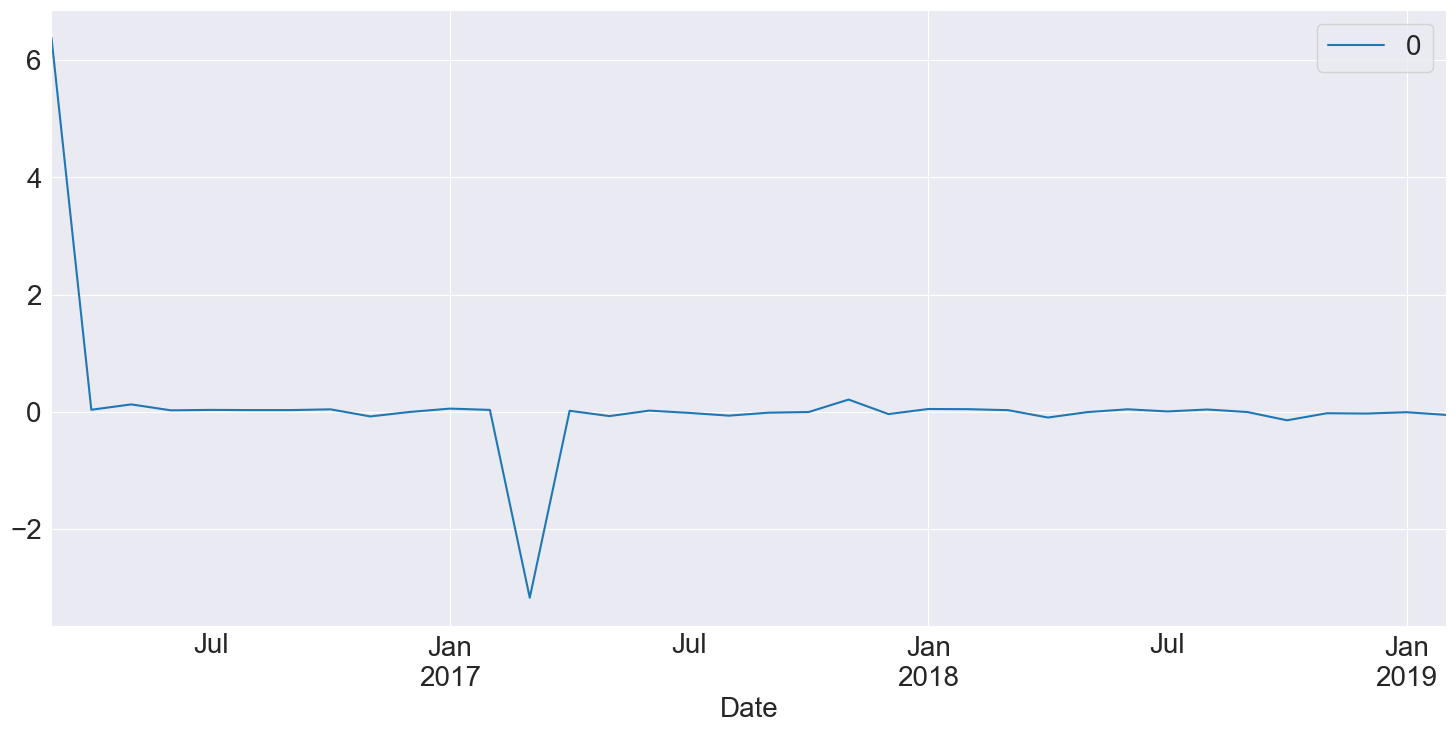

In [28]:
pandas.DataFrame(best_model2.resid).plot(label="resid")
plt.show()

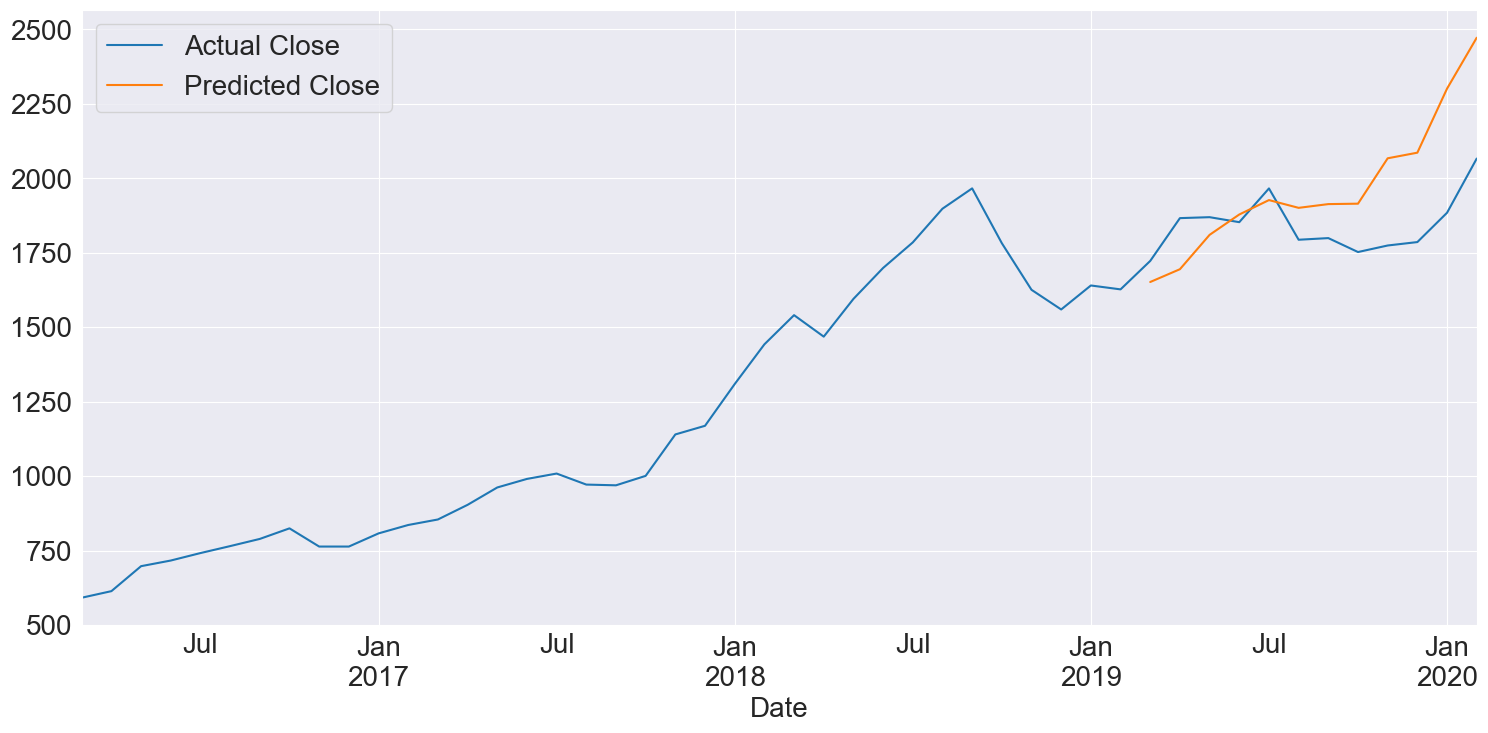

In [29]:
predicted2 = np.exp(best_model2.predict(start=0, end=last))

df["Close"].head(last).plot()
predicted2[train2:last].plot()
plt.legend(["Actual Close", "Predicted Close"])
plt.show()

In [27]:
mean_absolute_percentage_error(predicted2[train2+1:], df["Close"][train2:last])

0.10159003760056001